In [347]:
#Environment setup
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#libraries loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [348]:
data_bnb = pd.read_csv("BNB-USD.csv")# Data loading


data_bnb.head()#data viewing

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,2.05314,2.17423,1.89394,1.99077,1.99077,19192200,bnb_usd
1,2017-11-10,2.00773,2.06947,1.64478,1.79684,1.79684,11155000,bnb_usd
2,2017-11-11,1.78628,1.91775,1.61429,1.67047,1.67047,8178150,bnb_usd
3,2017-11-12,1.66889,1.67280,1.46256,1.51969,1.51969,15298700,bnb_usd
4,2017-11-13,1.52601,1.73502,1.51760,1.68662,1.68662,12238800,bnb_usd


In [349]:
data_bnb['Close'].value_counts() 

1.990770      1
269.102325    1
234.885437    1
249.851379    1
255.689667    1
             ..
29.641972     1
31.477377     1
32.707649     1
33.469681     1
271.591553    1
Name: Close, Length: 1837, dtype: int64

In [350]:
df = data_bnb.loc[(data_bnb['key'] == 'bnb_usd')]
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2017-11-09,2.05314,2.17423,1.89394,1.99077,1.99077,19192200,bnb_usd
1,2017-11-10,2.00773,2.06947,1.64478,1.79684,1.79684,11155000,bnb_usd
2,2017-11-11,1.78628,1.91775,1.61429,1.67047,1.67047,8178150,bnb_usd
3,2017-11-12,1.66889,1.67280,1.46256,1.51969,1.51969,15298700,bnb_usd
4,2017-11-13,1.52601,1.73502,1.51760,1.68662,1.68662,12238800,bnb_usd
5,2017-11-14,1.68928,1.73537,1.56827,1.59258,1.59258,7829600,bnb_usd
6,2017-11-15,1.58777,1.62498,1.49550,1.53045,1.53045,7615500,bnb_usd
7,2017-11-16,1.55619,1.68222,1.53689,1.57792,1.57792,8928640,bnb_usd
8,2017-11-17,1.58005,1.58266,1.49530,1.51036,1.51036,8508840,bnb_usd
9,2017-11-18,1.51136,1.67678,1.49823,1.67433,1.67433,32167300,bnb_usd


In [351]:
#date time collection
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2017-11-09')]

In [352]:
df = df[['Date','Open','Close','High','Low','Volume']]

In [353]:
df.head()

,Date,Open,Close,High,Low,Volume
1,2017-11-10,2.00773,1.79684,2.06947,1.64478,11155000
2,2017-11-11,1.78628,1.67047,1.91775,1.61429,8178150
3,2017-11-12,1.66889,1.51969,1.67280,1.46256,15298700
4,2017-11-13,1.52601,1.68662,1.73502,1.51760,12238800
5,2017-11-14,1.68928,1.59258,1.73537,1.56827,7829600


In [354]:
df = df[['Close']]

In [355]:
dataset = df.values
dataset = dataset.astype('float32')

In [356]:
dataset

array([[  1.79684],
       [  1.67047],
       [  1.51969],
       ...,
       [267.91132],
       [273.91998],
       [271.59155]], dtype=float32)

In [357]:
#Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [358]:
dataset_scale

array([[4.2493502e-04],
       [2.3749075e-04],
       [1.3839221e-05],
       ...,
       [3.9515179e-01],
       [4.0406445e-01],
       [4.0061069e-01]], dtype=float32)

In [359]:
#training set size
train_size = int(len(dataset_scale) * 0.709)
test_size = len(dataset_scale) - train_size
train, test = dataset_scale[0:train_size, :], dataset_scale[train_size:len(dataset), :]
print(len(train), len(test))

1301 535


In [360]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [361]:
look_back = 20
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [362]:
trainX
trainY
#testX
#testY

array([0.00072179, 0.00083045, 0.00085112, ..., 0.48099422, 0.52333546,
       0.535892  ], dtype=float32)

In [314]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [315]:
#Model set-up
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(trainX, trainY, epochs=500, batch_size=270, verbose=2)

Epoch 1/500
5/5 - 1s - loss: 0.0140 - 897ms/epoch - 179ms/step
Epoch 2/500
5/5 - 0s - loss: 0.0113 - 10ms/epoch - 2ms/step
Epoch 3/500
5/5 - 0s - loss: 0.0088 - 9ms/epoch - 2ms/step
Epoch 4/500
5/5 - 0s - loss: 0.0070 - 9ms/epoch - 2ms/step
Epoch 5/500
5/5 - 0s - loss: 0.0055 - 10ms/epoch - 2ms/step
Epoch 6/500
5/5 - 0s - loss: 0.0043 - 8ms/epoch - 2ms/step
Epoch 7/500
5/5 - 0s - loss: 0.0035 - 10ms/epoch - 2ms/step
Epoch 8/500
5/5 - 0s - loss: 0.0028 - 9ms/epoch - 2ms/step
Epoch 9/500
5/5 - 0s - loss: 0.0023 - 8ms/epoch - 2ms/step
Epoch 10/500
5/5 - 0s - loss: 0.0020 - 10ms/epoch - 2ms/step
Epoch 11/500
5/5 - 0s - loss: 0.0018 - 9ms/epoch - 2ms/step
Epoch 12/500
5/5 - 0s - loss: 0.0016 - 8ms/epoch - 2ms/step
Epoch 13/500
5/5 - 0s - loss: 0.0015 - 9ms/epoch - 2ms/step
Epoch 14/500
5/5 - 0s - loss: 0.0015 - 9ms/epoch - 2ms/step
Epoch 15/500
5/5 - 0s - loss: 0.0015 - 9ms/epoch - 2ms/step
Epoch 16/500
5/5 - 0s - loss: 0.0014 - 9ms/epoch - 2ms/step
Epoch 17/500
5/5 - 0s - loss: 0.0014 - 8m

Epoch 131/500
5/5 - 0s - loss: 4.7345e-04 - 8ms/epoch - 2ms/step
Epoch 132/500
5/5 - 0s - loss: 4.7045e-04 - 8ms/epoch - 2ms/step
Epoch 133/500
5/5 - 0s - loss: 4.6873e-04 - 9ms/epoch - 2ms/step
Epoch 134/500
5/5 - 0s - loss: 4.6962e-04 - 9ms/epoch - 2ms/step
Epoch 135/500
5/5 - 0s - loss: 4.6743e-04 - 9ms/epoch - 2ms/step
Epoch 136/500
5/5 - 0s - loss: 4.6389e-04 - 9ms/epoch - 2ms/step
Epoch 137/500
5/5 - 0s - loss: 4.6258e-04 - 8ms/epoch - 2ms/step
Epoch 138/500
5/5 - 0s - loss: 4.6062e-04 - 9ms/epoch - 2ms/step
Epoch 139/500
5/5 - 0s - loss: 4.6271e-04 - 8ms/epoch - 2ms/step
Epoch 140/500
5/5 - 0s - loss: 4.6041e-04 - 9ms/epoch - 2ms/step
Epoch 141/500
5/5 - 0s - loss: 4.5700e-04 - 9ms/epoch - 2ms/step
Epoch 142/500
5/5 - 0s - loss: 4.5751e-04 - 8ms/epoch - 2ms/step
Epoch 143/500
5/5 - 0s - loss: 4.5349e-04 - 9ms/epoch - 2ms/step
Epoch 144/500
5/5 - 0s - loss: 4.5198e-04 - 8ms/epoch - 2ms/step
Epoch 145/500
5/5 - 0s - loss: 4.5193e-04 - 9ms/epoch - 2ms/step
Epoch 146/500
5/5 - 0s - 

5/5 - 0s - loss: 3.3631e-04 - 9ms/epoch - 2ms/step
Epoch 258/500
5/5 - 0s - loss: 3.3475e-04 - 8ms/epoch - 2ms/step
Epoch 259/500
5/5 - 0s - loss: 3.3301e-04 - 8ms/epoch - 2ms/step
Epoch 260/500
5/5 - 0s - loss: 3.3562e-04 - 8ms/epoch - 2ms/step
Epoch 261/500
5/5 - 0s - loss: 3.3300e-04 - 8ms/epoch - 2ms/step
Epoch 262/500
5/5 - 0s - loss: 3.3330e-04 - 8ms/epoch - 2ms/step
Epoch 263/500
5/5 - 0s - loss: 3.3482e-04 - 8ms/epoch - 2ms/step
Epoch 264/500
5/5 - 0s - loss: 3.3334e-04 - 8ms/epoch - 2ms/step
Epoch 265/500
5/5 - 0s - loss: 3.3047e-04 - 8ms/epoch - 2ms/step
Epoch 266/500
5/5 - 0s - loss: 3.2842e-04 - 9ms/epoch - 2ms/step
Epoch 267/500
5/5 - 0s - loss: 3.2828e-04 - 8ms/epoch - 2ms/step
Epoch 268/500
5/5 - 0s - loss: 3.2784e-04 - 8ms/epoch - 2ms/step
Epoch 269/500
5/5 - 0s - loss: 3.2777e-04 - 9ms/epoch - 2ms/step
Epoch 270/500
5/5 - 0s - loss: 3.2962e-04 - 8ms/epoch - 2ms/step
Epoch 271/500
5/5 - 0s - loss: 3.2863e-04 - 9ms/epoch - 2ms/step
Epoch 272/500
5/5 - 0s - loss: 3.2504e-

Epoch 384/500
5/5 - 0s - loss: 2.7854e-04 - 9ms/epoch - 2ms/step
Epoch 385/500
5/5 - 0s - loss: 2.8094e-04 - 7ms/epoch - 1ms/step
Epoch 386/500
5/5 - 0s - loss: 2.7955e-04 - 9ms/epoch - 2ms/step
Epoch 387/500
5/5 - 0s - loss: 2.8064e-04 - 8ms/epoch - 2ms/step
Epoch 388/500
5/5 - 0s - loss: 2.7865e-04 - 8ms/epoch - 2ms/step
Epoch 389/500
5/5 - 0s - loss: 2.7668e-04 - 8ms/epoch - 2ms/step
Epoch 390/500
5/5 - 0s - loss: 2.7764e-04 - 8ms/epoch - 2ms/step
Epoch 391/500
5/5 - 0s - loss: 2.7724e-04 - 8ms/epoch - 2ms/step
Epoch 392/500
5/5 - 0s - loss: 2.7911e-04 - 8ms/epoch - 2ms/step
Epoch 393/500
5/5 - 0s - loss: 2.7545e-04 - 9ms/epoch - 2ms/step
Epoch 394/500
5/5 - 0s - loss: 2.7863e-04 - 8ms/epoch - 2ms/step
Epoch 395/500
5/5 - 0s - loss: 2.7963e-04 - 8ms/epoch - 2ms/step
Epoch 396/500
5/5 - 0s - loss: 2.7640e-04 - 8ms/epoch - 2ms/step
Epoch 397/500
5/5 - 0s - loss: 2.7839e-04 - 8ms/epoch - 2ms/step
Epoch 398/500
5/5 - 0s - loss: 2.7433e-04 - 8ms/epoch - 2ms/step
Epoch 399/500
5/5 - 0s - 

In [317]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

17/17 [==============================] - 0s 915us/step


In [318]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [319]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 10.72 RMSE
Test Score: 21.26 RMSE


In [320]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [321]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

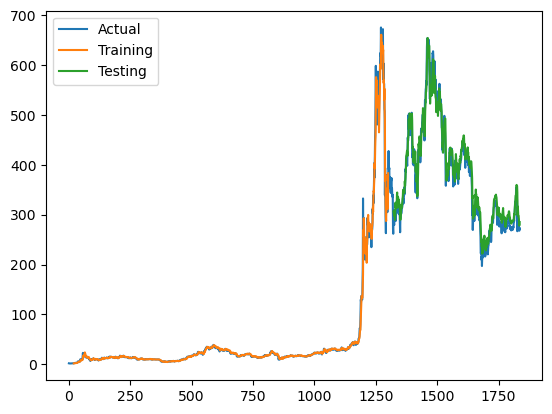

In [322]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [323]:
from sklearn.metrics import mean_squared_error

mean_squared_error(testY[0].reshape(-1),testPredict[:, 0])



452.08933727596474

In [325]:
    from keras.models import load_model
    model.save('bnb.h5') 
    model.save_weights('bnb_weights.h5')  # to store